In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import scienceplots

plt.style.use("science")

## Preliminary data analysis

In [2]:
data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df["class"] = df["target"] // 10
df.head()

,filename,fold,target,category,esc10,src_file,take,class
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [3]:
data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df = df.query("esc10 == True").reset_index()

from sklearn.preprocessing import OneHotEncoder

categories = df["category"].to_numpy()

encoder = OneHotEncoder()
target = encoder.fit_transform(categories.reshape(-1, 1)).toarray()
df["target"] = target.tolist()
df["class"] = df["target"].apply(lambda x: np.argmax(x))

df.head()

,index,filename,fold,target,category,esc10,src_file,take,class
0,0,1-100032-A-0.wav,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",dog,True,100032,A,4
1,14,1-110389-A-0.wav,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",dog,True,110389,A,4
2,24,1-116765-A-41.wav,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chainsaw,True,116765,A,0
3,54,1-17150-A-12.wav,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",crackling_fire,True,17150,A,2
4,55,1-172649-A-40.wav,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",helicopter,True,172649,A,5


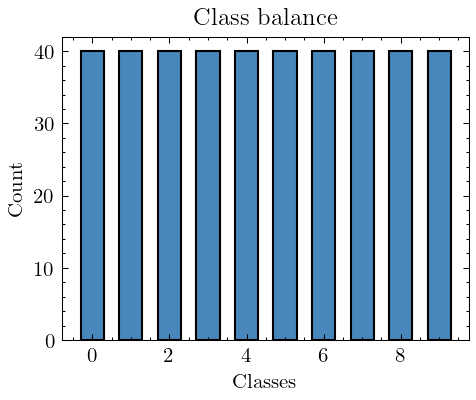

In [4]:
plt.figure(dpi=150)
sns.histplot(df, x="class", discrete=True, shrink=0.6)
plt.title("Class balance")
plt.xlabel("Classes")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "class_balance.png"), dpi=150)
plt.show()

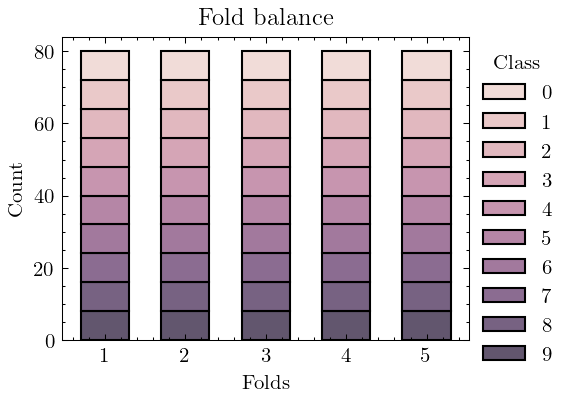

In [5]:
plt.figure(dpi=150)
sns.histplot(df, x="fold", hue="class", discrete=True, shrink=0.6, multiple="stack")
sns.move_legend(plt.gca(), loc="upper right", bbox_to_anchor=(1.25, 1), title="Class")
plt.title("Fold balance")
plt.xlabel("Folds")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "fold_balance.png"), dpi=150)
plt.show()

## Feature extraction

### Resampling

In [57]:
import torch
import torchaudio


class myPipeline(torch.nn.Module):
    def __init__(
        self,
        n_mfcc: int = 40,
        sample_rate=44100,
        mtWin=1,
        mtStep=0.5,
        stWin=0.02,
        stStep=0.01,
    ):
        super().__init__()
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.mtWin = np.floor(mtWin * sample_rate)
        self.mtStep = np.floor(mtStep * sample_rate)
        self.stWin = np.floor(stWin * sample_rate)
        self.stStep = np.floor(stStep * sample_rate)

        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={"n_fft": self.n_ftt, "hop_length": self.hop_length},
            log_mels=self.log_mels,
        )

    def forward(self, waveform: torch.Tensor, sample_rate) -> torch.Tensor:
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sample_rate, self.sample_rate
            )
        mfcc = self.mfcc(waveform)
        (zcr_mean, zcr_std) = self.ZeroCrossingRate(waveform)

        return

    def mtWindowize(
        self, waveform: torch.Tensor, mtWin: int, mtStep: int
    ) -> torch.Tensor:
        mtWindows = waveform.unfold(1, mtWin, mtStep)
        return mtWindows

    def stWindowize(
        self, waveform: torch.Tensor, stWin: int, stStep: int
    ) -> torch.Tensor:
        stWindows = waveform.unfold(1, stWin, stStep)
        return stWindows

    def ZeroCrossingRate(
        self, waveform: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        mtWindows = self.mtWindowize(waveform, self.mtWin, self.mtStep)
        for mtWindow in mtWindows:
            stWindows = self.stWindowize(mtWindow, self.stWin, self.stStep)
            zcr = torch.zeros(stWindows.shape[0])
            for i, stWindow in enumerate(stWindows):
                zcr[i] = (
                    1
                    / (2 * len(stWindow))
                    * torch.sum(torch.abs(torch.diff(torch.sign(stWindow))))
                )
            mtZCR = torch.mean(zcr)
        return mtZCR.mean(), mtZCR.std()

### MFCC

In [6]:
import torch
import torchaudio


class MFCCExtractor(torch.nn.Module):
    def __init__(
        self,
        n_mfcc: int = 40,
        sample_rate=44100,
        n_fft: int = 2048,
        hop_length: int = 512,
        log_mels: bool = True,
    ):
        super().__init__()
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.n_ftt = n_fft
        self.hop_length = hop_length
        self.log_mels = log_mels

        self.resample = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=self.sample_rate
        )
        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={"n_fft": self.n_ftt, "hop_length": self.hop_length},
            log_mels=self.log_mels,
        )

    def forward(self, waveform: torch.Tensor, sample_rate) -> torch.Tensor:
        if sample_rate != self.sample_rate:
            waveform = self.resample(waveform, sample_rate)
        mfcc = self.mfcc(waveform)
        return mfcc

In [7]:
n_mfcc = 40
mfcc_extractor = myPipeline(n_mfcc=n_mfcc)
mfccs_mean = torch.zeros((len(df), n_mfcc))
mfccs_std = torch.zeros((len(df), n_mfcc))
zcrs_mean = torch.zeros(len(df))
zcrs_std = torch.zeros(len(df))
for i, row in tqdm(df.iterrows()):
    waveform, sample_rate = torchaudio.load(
        os.path.join(data_dir, "audio", row["filename"]),
    )
    mfcc = mfcc_extractor(waveform, sample_rate)
    mfccs_mean[i] = mfcc.mean(dim=2)
    mfccs_std[i] = mfcc.std(dim=2)
    zcrs_mean[i] = mfcc_extractor.ZeroCrossingRate(waveform)
    zcrs_std[i] = mfcc_extractor.ZeroCrossingRate(waveform)

400it [00:02, 184.53it/s]


## PCA

array([0.3593912, 0.1343477], dtype=float32)

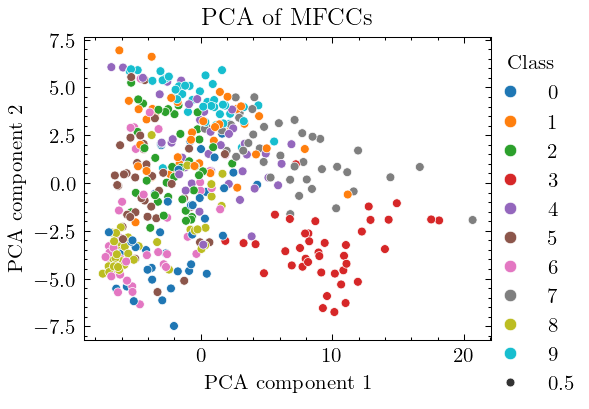

In [8]:
from sklearn.decomposition import PCA

# Standardize MFCCs
mfccs_mean = (mfccs_mean - mfccs_mean.mean(dim=0)) / mfccs_mean.std(dim=0)
mfccs_std = (mfccs_std - mfccs_std.mean(dim=0)) / mfccs_std.std(dim=0)

pca = PCA(n_components=2)
mfccs_pca = pca.fit_transform(np.concatenate([mfccs_mean, mfccs_std], axis=1))
display(pca.explained_variance_ratio_)

# Plot PCA
plt.figure(dpi=150)
sns.scatterplot(
    x=mfccs_pca[:, 0],
    y=mfccs_pca[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
sns.move_legend(plt.gca(), loc="upper right", bbox_to_anchor=(1.25, 1), title="Class")
plt.title("PCA of MFCCs")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca.png"), dpi=150)
plt.show()

## Experiments

### SVM

In [56]:
# Train an SVM with rbf kernel with onevsrest strategy
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

X = np.concatenate([mfccs_mean, mfccs_std], axis=1)
y = df["class"]
clf = make_pipeline(OneVsRestClassifier(SVC(kernel="rbf", C=1)))
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.65 (+/- 0.16)


In [55]:
# Train an MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

X = np.concatenate([mfccs_mean, mfccs_std], axis=1)
y = df["class"]
clf = make_pipeline(
    MLPClassifier(
        hidden_layer_sizes=(70, 50),
        max_iter=10000,
        n_iter_no_change=10,
        solver="sgd",
        activation="tanh",
        learning_rate_init=0.01,
        random_state=42,
    ),
)
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.68 (+/- 0.18)
